In [11]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
!pip install pyserial

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
!pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

import serial
import time

import control
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import differential_evolution

In [15]:
def remove_noise(img):
    kernel = np.ones((7, 7), np.uint8)
    iterations = 1
    img1 = img.copy()
    img1 = cv2.erode(img1, kernel, iterations)
    img1 = cv2.dilate(img1, kernel, iterations)
    
    return img1

In [16]:
def find_the_centre(mask):

    x, y = np.where(mask == 255)
    n = len(x)
    if n == 0:
        n = 1
    x_final = int(sum(x) / n)
    y_final = int(sum(y) / n)
    
    return x_final, y_final

In [17]:
def frame_work(frame):
               
    #rotiranje,
    #binaroizacija na osnovu narandzaste boje
    #i nalazenje centra 
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    
    orange_hsv = [20, 200, 200]
    
    indikator = frame.copy()
    indikator[:, :] = [0, 0, 255]
    
    treshold = 50

    mask = cv2.inRange(frame, (6, 100, 130), (30, 255, 255))  

    frame = cv2.cvtColor(frame, cv2.COLOR_HSV2BGR)
    mask = remove_noise(mask)
    
    x, y = find_the_centre(mask)
    
    #frame[x-5 : x+5, y-5 : y+5, :] = [255, 0, 255]
            
    position = [x, y]    
    
    return frame, mask, position

In [18]:
def fix_pos(pos, frame):
    x = pos[1]
    y = frame.shape[0] - pos[0]
    return x, y

In [21]:
#Samo snimanje kamere i filtriranje narandzaste boje(loptice)

cap = cv2.VideoCapture(1)
set_color = True

while cap.isOpened():
    
    ret, frame = cap.read()
    
    frame, mask, position = frame_work(frame)
    
    cv2.imshow('Webcam', frame)
    cv2.imshow('Filtrirano', mask)
    
   # cv2.imshow('Nadjena boja', indikator)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
#Koristiti ovaj blok da se oslobodi otvorenih ekrana

cap.release()
cv2.destroyAllWindows()

Uvodimo vezi sa Arduinom

In [ ]:
#Koristiti ovaj blok da se oslobodi otvorenih ekrana i otvorenih COMova

serialcomm.close()
cap.release()
cv2.destroyAllWindows()

In [ ]:
#Pise vrednost na serial comm (sto arduino kod treba da cita i koristi dalje)

serialcomm = serial.Serial('COM4', 9600)
serialcomm.timeout = 1
while True:

    flash = int(input())
    if flash == 666.0:
        break
    serialcomm.write((str(flash) + '\n').encode())

serialcomm.close()

In [ ]:
#Belezimo najvecu visinu do koje loptica moze stici
#(treba uraditi i za najmanju i podesiti kod ili postaviti kameru tako da dno slike bude dno cevi)

cap = cv2.VideoCapture(0)
set_color = True

serialcomm = serial.Serial('COM4', 9600)
serialcomm.timeout = 1
 
max_height = 0
k = 255
start = time.time()

for i in range(100):
    
    ret, frame = cap.read()
    frame, mask, pos = frame_work(frame)
    
    x, y = fix_pos(pos, frame)
    if y == frame.shape[0]: 
        y = 0
    
    serialcomm.write((str(k) + '\n').encode())

    if y > max_height:
        max_height = y
        
    time.sleep(0.02)
    
end = time.time()
vreme = end - start

print("END PROCESS")
print("time = ", vreme)
print("max_height = ", max_height)

serialcomm.write((str(0) + '\n').encode())
serialcomm.close()
cap.release()
cv2.destroyAllWindows() 

In [ ]:
from control import *

In [ ]:
s = tf('s')

In [ ]:
#Postavljamo PID kontroler bez simulacije, samo cemo ubosti vrednosti

serialcomm.close()
cap.release()
cv2.destroyAllWindows() 

serialcomm.close()
cap.release()
cv2.destroyAllWindows() 

cap = cv2.VideoCapture(0)
set_color = True

serialcomm = serial.Serial('COM5', 9600)
serialcomm.timeout = 1

#Ovi koeficijenti se stimuju
Kp = 30
Ki = 0.55
Kd = 150

n = 1000

data_test = np.zeros(n)
data_u = np.zeros(n)

target_position = 0.5

new_position = 0
old_position = 0

new_difference = target_position
old_difference = 0

sum_of_differences = 0

new_u = 0
old_u = 0

k = 255
u = 0

#ovo NISU koeficijenti, njih OSTAVITI na 0
P = 0
I = 0
D = 0

start = time.time()

for i in range(n):
    
    ret, frame = cap.read()
    frame, mask, pos = frame_work(frame)
    
    #Crta kvadrat na postavljenoj visini radi reference
    #h = int(target_position * frame.shape[0])
    #frame[h - 5 : h + 5, 100:110, :] = [0, 255, 0]
    
    x, y = fix_pos(pos, frame)
    if y == frame.shape[0]: 
        y = 0
    
    old_position = new_position
    new_position = y / max_height
    
    #Racunamo P, I i D komponentu
    old_difference = new_difference
    new_difference = target_position - new_position
    P = Kp * new_difference
    
    D = Kd * (new_difference - old_difference)
    
    if( sum_of_differences + Ki * new_difference < 1):
        sum_of_differences += Ki * new_difference
    I = sum_of_differences    
    
    new_u = P + I + D

    #Odseca napon u zeljenom opsegu
    if new_u < 0:
        new_u = 0
    if new_u > 1:
        new_u = 1
        
    #Ispisuje vrednost u na serial comm
    serialcomm.write((str(int(new_u * k)) + '\n').encode())
    
    #apisujemo vrednosti radi crtanja grafika kasnije
    data_u[i] = new_u
    data_test[i] = y / frame.shape[0]
    
    time.sleep(0.01)
    
    cv2.imshow('Webcam', frame)
    cv2.imshow('Filtrirano', mask)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("finished program")
        break
    
end = time.time()
vreme = end - start

print("END PROCESS")
print("time = ", vreme)

#Iskljuci motor i disconnectuj sve 
serialcomm.write((str(0) + '\n').encode())
serialcomm.close()
cap.release()
cv2.destroyAllWindows() 

END PROCESS
time =  33.77502465248108


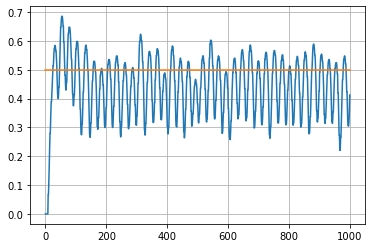

In [ ]:
#Crtamo grafik prethodnog eksperimenta

plt.figure()
plt.plot(data_test)
plt.plot([target_position]*len(data_test))
#plt.plot(data_u)
plt.grid()
plt.show()

In [ ]:
#Ovaj blok radi isto sto i prosli ali vecno i ne beleyi vrednosti ya crtanje grafika

serialcomm.close()
cap.release()
cv2.destroyAllWindows() 

serialcomm.close()
cap.release()
cv2.destroyAllWindows() 

cap = cv2.VideoCapture(0)
set_color = True

serialcomm = serial.Serial('COM5', 9600)
serialcomm.timeout = 1

#Ovi koeficijenti se stimuju
Kp = 20
Ki = 0.5
Kd = 150

target_position = 0.5

new_position = 0
old_position = 0

new_difference = target_position
old_difference = 0

sum_of_differences = 0

new_u = 0
old_u = 0

k = 255
u = 0

P = 0
I = 0
D = 0

start = time.time()

while(True):
    
    ret, frame = cap.read()
    frame, mask, pos = frame_work(frame)
    
    #Crta kvadrat na postavljenoj visini radi reference
    #h = int(target_position * frame.shape[0])
    #frame[h - 5 : h + 5, 100:110, :] = [0, 255, 0]
    
    x, y = fix_pos(pos, frame)
    if y == frame.shape[0]: 
        y = 0
    
    old_position = new_position
    new_position = y / max_height
    
    old_difference = new_difference
    new_difference = target_position - new_position
    P = Kp * new_difference
    
    D = Kd * (new_difference - old_difference)
    
    if( sum_of_differences + Ki * new_difference < 1):
        sum_of_differences += Ki * new_difference
    I = sum_of_differences    
    
    new_u = P + I + D

    if new_u < 0:
        new_u = 0
    if new_u > 1:
        new_u = 1
    
    serialcomm.write((str(int(new_u * k)) + '\n').encode())
    
    time.sleep(0.01)
    
    cv2.imshow('Webcam', frame)
    cv2.imshow('Filtrirano', mask)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("finished program")
        break
    
end = time.time()
vreme = end - start

print("END PROCESS")
print("time = ", vreme)

#Iskljuci motor i disconnectuj sve 
serialcomm.write((str(0) + '\n').encode())
serialcomm.close()
cap.release()
cv2.destroyAllWindows() 

finished program
END PROCESS
time =  4432.663214445114
